In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
import wfdb
from sklearn.preprocessing import Normalizer
from matplotlib import colors
from scipy.stats import norm
import random 

plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

### Load the preprocessed_signals. 

In [2]:

afdb_signals = pickle.load(open("afdb_signals.p", "rb"))

r_peaks_afdb = pickle.load(open("afdb_ann.p", "rb"))

sinus_signals = pickle.load(open("ns_signals.p", "rb"))

r_peaks_sinus = pickle.load(open("ns_ann.p", "rb"))

# Random Synthetic Beat Extraction

In [3]:
def extract_rand_sinus_beats(sig,rpeaks,back,forward,N):
    """
       Extracts the beats from the signal randomly.

            Parameters
            ----------
            sig : sample
                numpy array of single channel ecg from the wfdbdb-records
            rpeaks:
                rpeaks of sig
            back:
                beat starting point
            forward:
                beat ending point
            N:
                number of beats to extract
            Returns
            -------
            beats, number of beats extracted
    """
    rpeaks=rpeaks.sample
    random_idx = []
    beats=[]
    for i in range(0,N):
        n = random.randint(1,len(rpeaks))
        random_idx.append(n)
    #print(random_idx)
    for j in random_idx:
        beat_start=rpeaks[j]-back
        beat_end=rpeaks[j]+forward

        beat=sig[beat_start:beat_end]
        beats.append(beat)
    return beats,N

In [4]:
def plot_beats(sample,N):
    """
        Plots the beats.

            Parameters
            ----------
            sample : numpy array
                numpy array of single channel ecg from the wfdbdb-records
            N:
                number of extracted beats per sample
            Returns
            -------
            None
    """
    if (N >1):
        fig, ax = plt.subplots(len(sample), N, figsize=(8,20),sharex=True)

        for beat in range(len(sample)):
            for x in range(0,N):

                ax[beat,x].plot(sample[beat][x])
    else:
        fig, ax = plt.subplots(len(sample), N, figsize=(5,20),sharex=True)

        for beat in range(len(sample)):


                ax[beat].plot(sample[beat][0])

##### In normal sinus rhytms almost all the signal looks same except for few beats that have noise. More or less all the signal looks same so beats from Normal Sinus Ryhtms were taken randomly. The visualisation of samples can be done through this link https://physionet.org/lightwave/?db=nsrdb/1.0.0


sinus_beats_temp=[]
for sample in range(len(sinus_signals)):
    beat,N=extract_rand_sinus_beats(sinus_signals[sample],r_peaks_sinus[sample],125,125,N=1)
    sinus_beats_temp.append(beat)

plot_beats(sinus_beats_temp,N)


#Only run this if you are satisfied with the beats.

sinus_beats=sinus_beats_temp
pickle.dump(sinus_beats,open("sinus_beats_to_model.p","wb"))

sinus_beats
plot_beats(sinus_beats,N)

## Loading saved sinus beats to model 

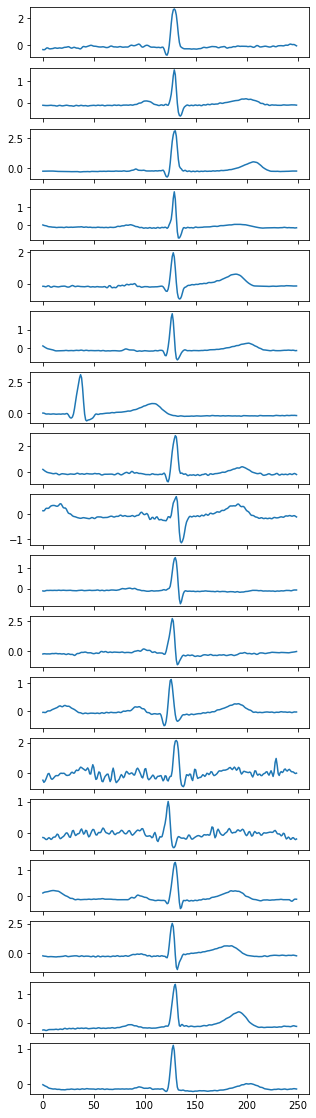

In [5]:
sinus_beats=pickle.load(open("sinus_beats_to_model.p","rb"))
plot_beats(sinus_beats,1)

In [34]:
# This codeblock generates synthetic beats according to params provided to syntmodel.

from syntmodel.synt_gen import model, generate_randomset
from syntmodel.utils_model import Prms 

def generate_synth_beats(params,n=1, fs=250, mode = "normal", rr = 0):
    
    """
       Generates Synthetic Beats
       
        Parameters
        ----------
        params : tuples,
        n: number of beats to generate,
        fs: Sampling rate

        Returns
        -------
        ecg_clean: cleaned beat,
        noise_stream: noise, 
        p_inds: p-index, 
        q_inds: q-index,
        r_inds: r-peak_index,
        s_inds: s-index
        t_inds: t-index 
    """
    _prms = Prms(**params)
    #_prms.scale_limits(3,3,3,0.1)
    ecg_clean, noise_stream, (p_inds,q_inds,r_inds,s_inds,t_inds) = model(n, _prms, fs,mode, rr)
    time=np.linspace(0,len(ecg_clean)/fs,len(ecg_clean))*len(ecg_clean)
    return ecg_clean,noise_stream, p_inds,q_inds,r_inds,s_inds,t_inds,time 

def generate_synth_randomset(params,fs,sample_len,n_sample):
     dataset, noiseset = generate_randomset(params,fs,sample_len,n_sample)
    
     return dataset, noiseset 
        

In [3]:
def transform_data(params):
    '''
    Transforms the params into object to save the params to pickle. 
    
    Parameters: 
    params: tuple of tuples
    
    Returns: 
    params_obj: object
    
    '''
    params_obj = {}
    
    for variable, value in params:

        params_obj[variable] = value
    
    return params_obj


### Generate Synth beats to mimic real sinus beats stored in `sinus_beats` one by one. 

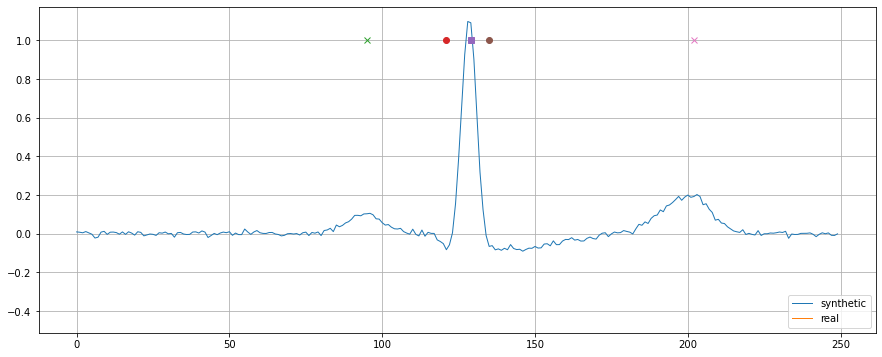

In [19]:
#This code block generates sinus synthetic beats based on params. Params are set manually and plotted.

n=1
fs=250
params = (
    ('pa', 0.1), ('qa', -0.1), ('ra', 1.2), ('sa', -0.09), ('ta', 0.2),
    ('pb', 0.15), ('qb', 0.04), ('rb', 0.06), ('sb', 0.15), ('tb', 0.25),
    ('pd', -0.12), ('qd', -0.015), ('rd', 0.017), ('sd', 0.04), ('td', 0.31),
    ('pm', 1.0), ('qm', 1.0), ('rm', 1.0), ('sm', 0.1), ('tm', 3.0),
    ('mu', 1.0), ('a', 1.2), ('std', 0.5), ('b', 0.075), ('bc', 0.1), ('bf', 1/3.6),
    ('alpha', 0.1), ('c', 0.1), ('wn', 0.0)
)
    
params_dict = dict(params)
ecg_clean, noise_stream, p_inds,q_inds,r_inds,s_inds,t_inds , synth_beat_time = generate_synth_beats(params_dict,n,fs)
synth_beat= ecg_clean+noise_stream
beat = sinus_signals[17][0]
#beat = StandardScaler().fit_transform(beat.reshape(-1,1))
#synth_beat = StandardScaler().fit_transform(synth_beat.reshape(-1,1))
plt.plot(synth_beat)
plt.plot(beat)
plt.legend(["synthetic", "real"], loc ="lower right")
plt.plot(p_inds, np.ones(len(p_inds)),'x')
plt.plot(q_inds, np.ones(len(q_inds)),'o')
plt.plot(r_inds, np.ones(len(r_inds)),'s')
plt.plot(s_inds, np.ones(len(s_inds)),'o')
plt.plot(t_inds, np.ones(len(t_inds)),'x')

#### Saved the params already 
prm_obj_dump = transform_data(params)

pickle.dump(prm_obj_dump,open("synth_params/sinus_synth_beat_18.p","wb"))



## Generate Synth beats to mimic real afib beats

In [1121]:
afib_beats_to_model = []

In [1109]:
sample = 0

atr = wfdb.rdann(afdb_records[sample], 'atr', pn_dir='afdb',summarize_labels=True) #reading annotation files for R_peak locations
print(atr.sample)


[     30  102584  119604  121773  122194  133348  166857 1096245 1098054
 1135296 1139595 1422436 1423548 1459277 1460416]


133348


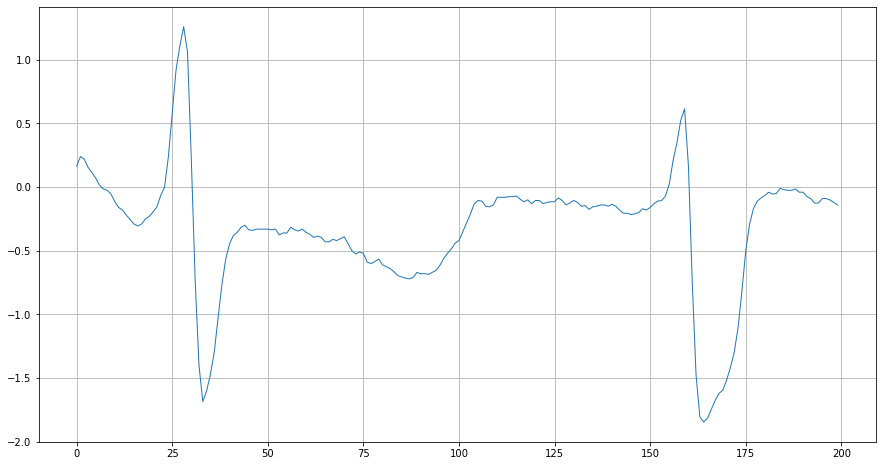

In [1137]:

x= atr.sample
x = x[x>30 ]
x = x[4]
print(x)

offset = 100
beat_start=x-offset
beat_end=x+offset       
beat=afdb_signals[sample]
beat=beat[beat_start:beat_end]

plt.figure(figsize=(15,8))
plt.plot(beat)


<ipython-input-4-2bc86fbc7d22>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,8))


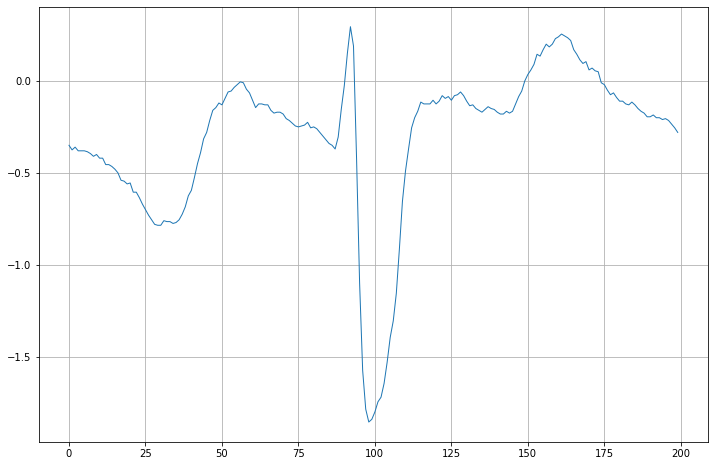

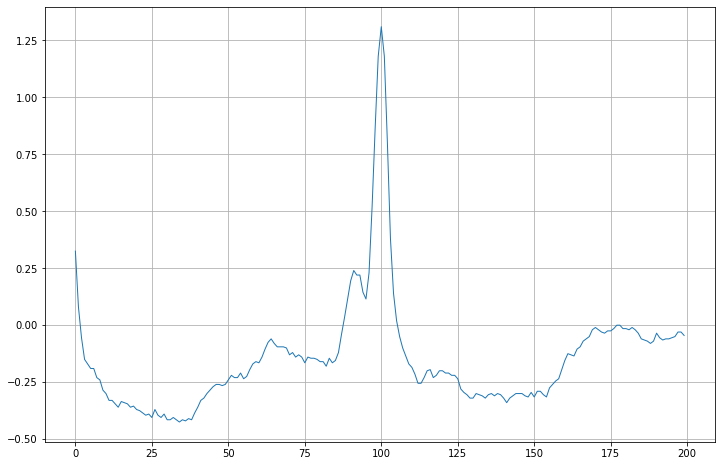

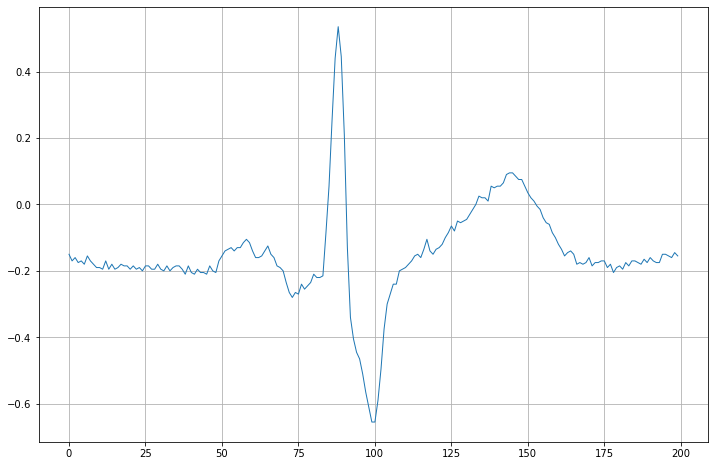

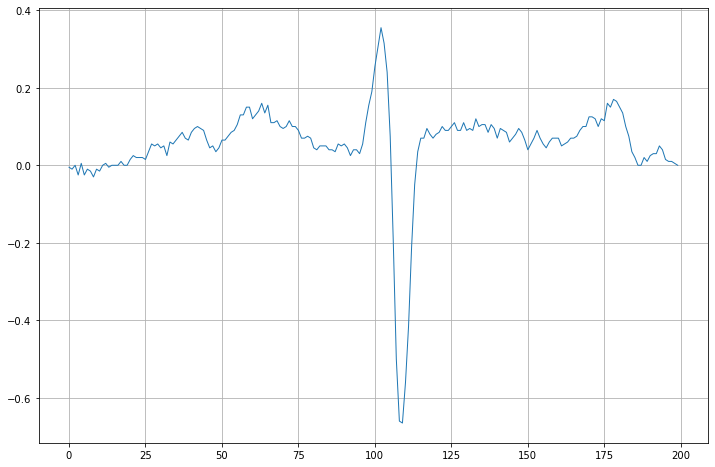

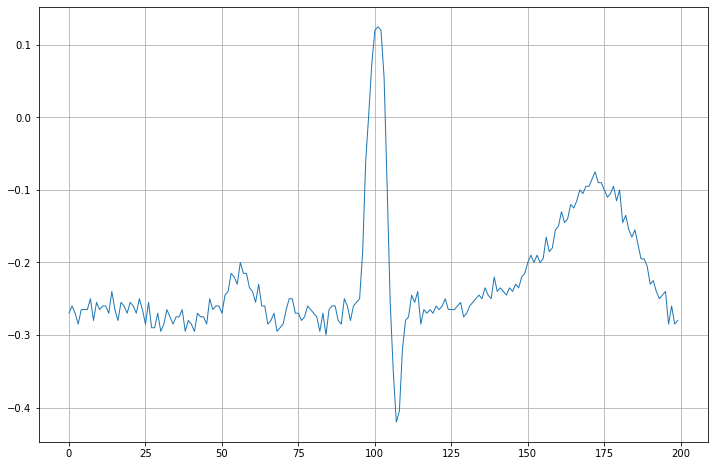

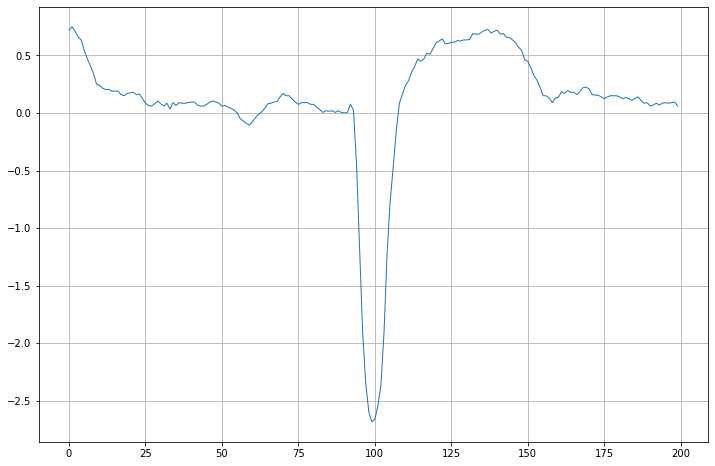

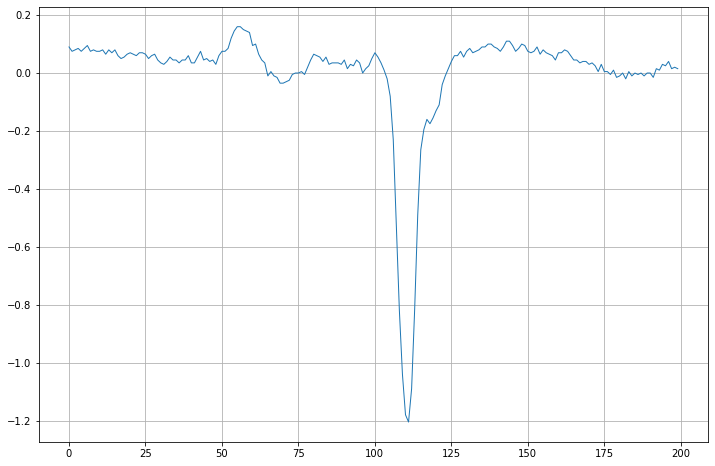

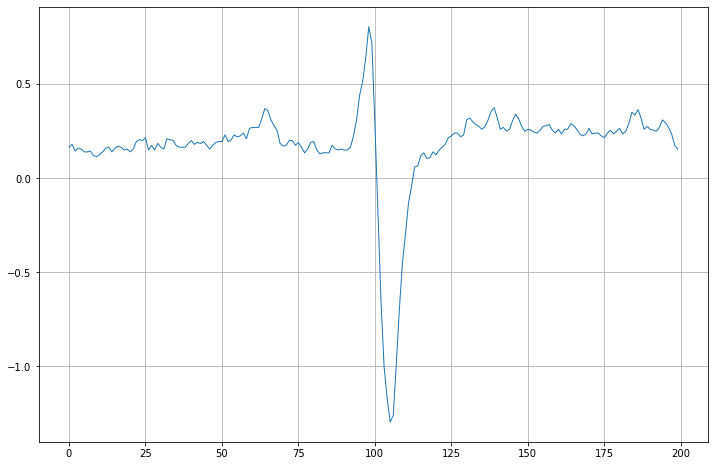

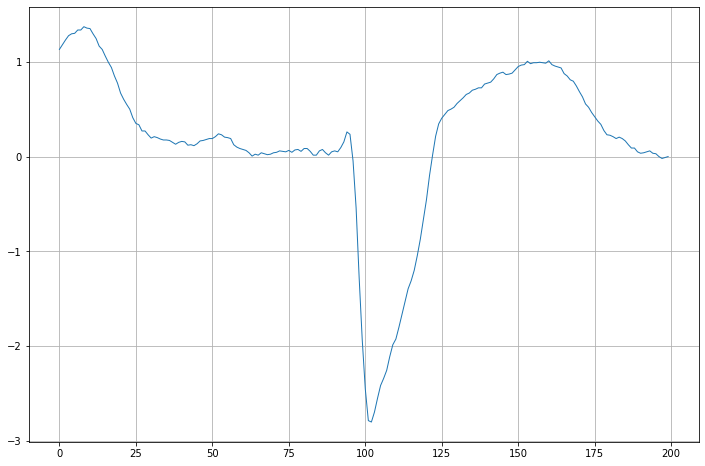

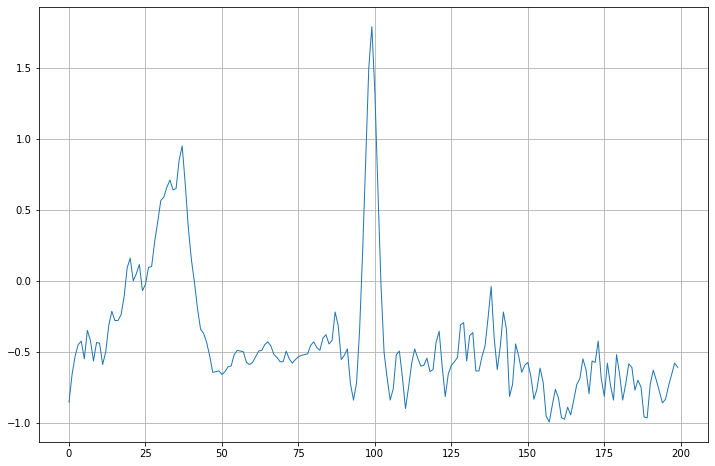

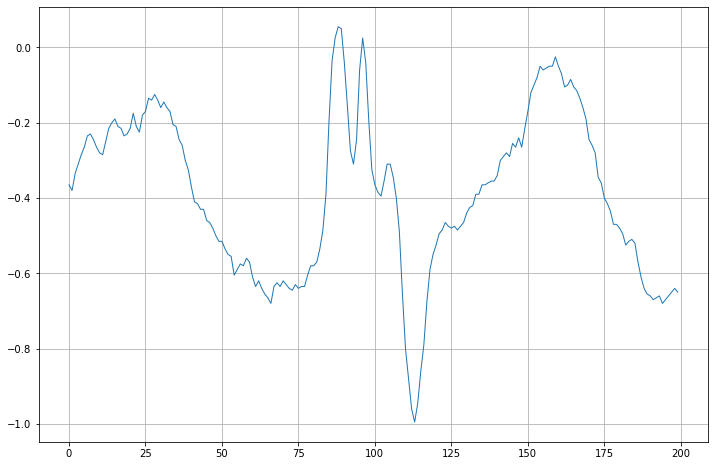

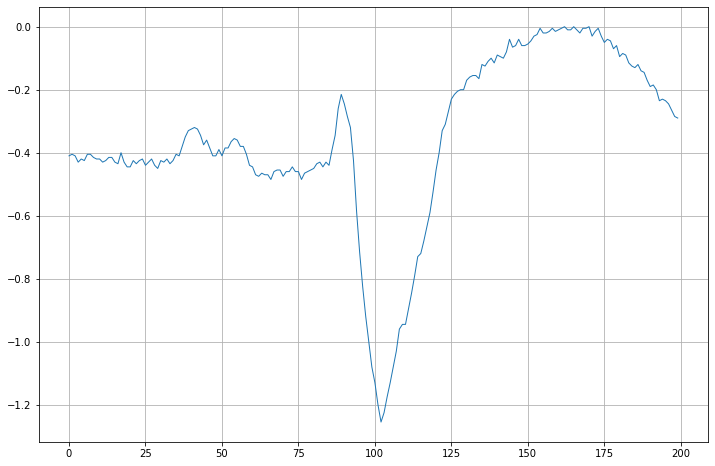

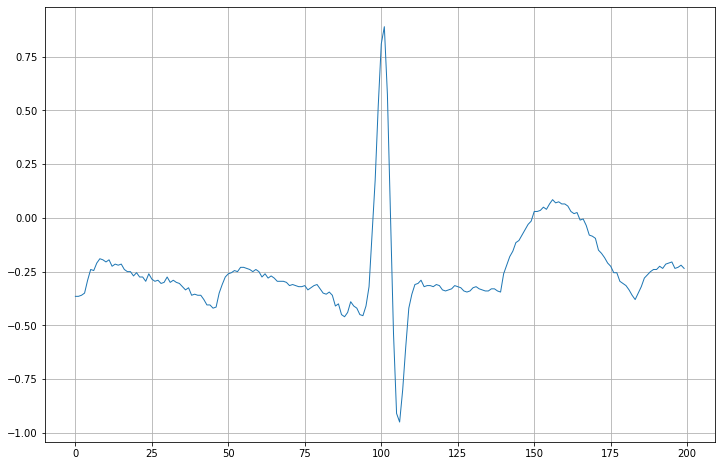

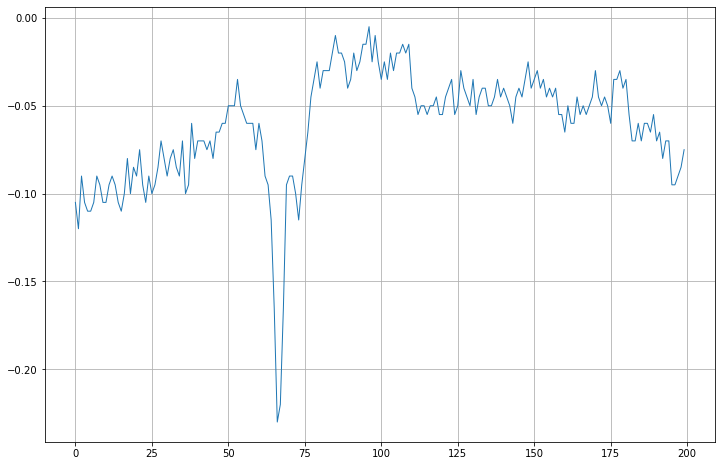

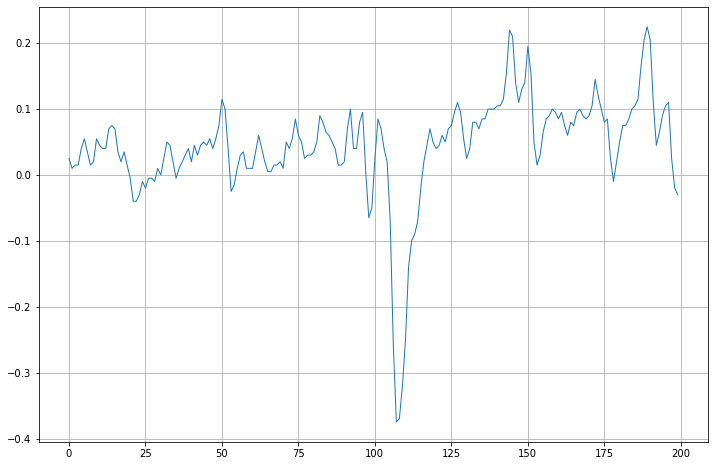

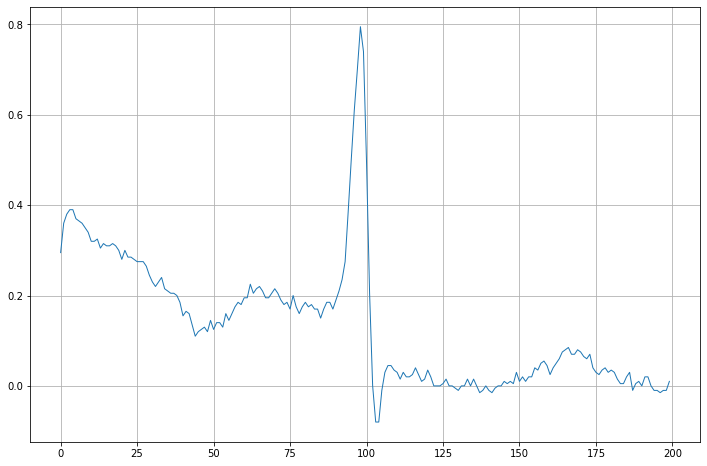

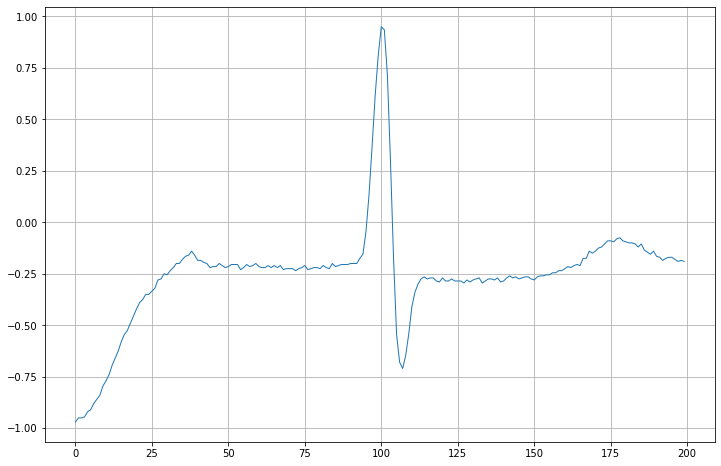

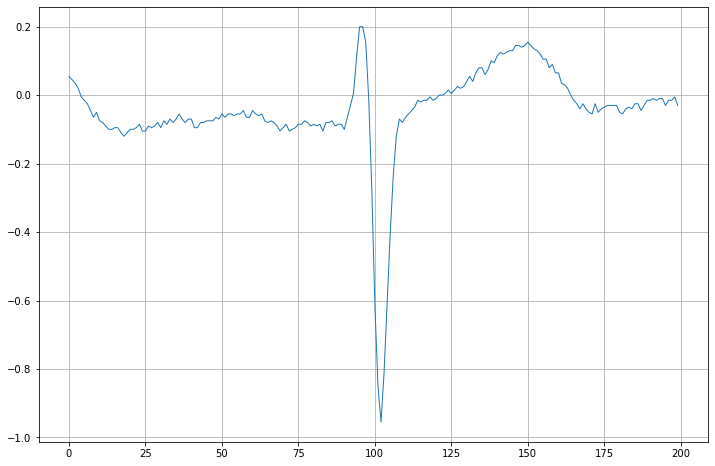

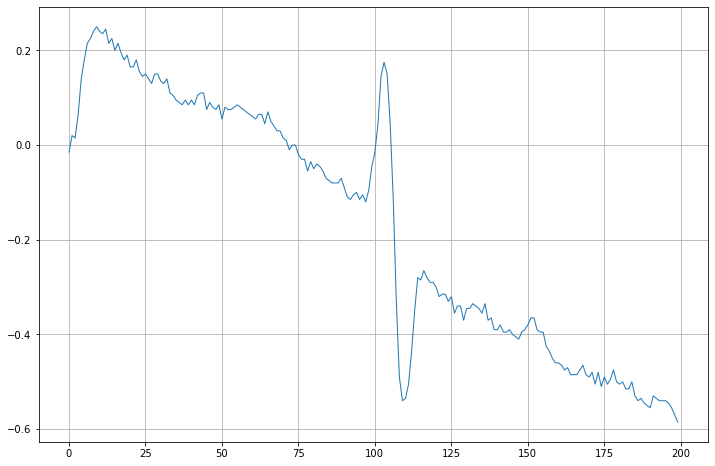

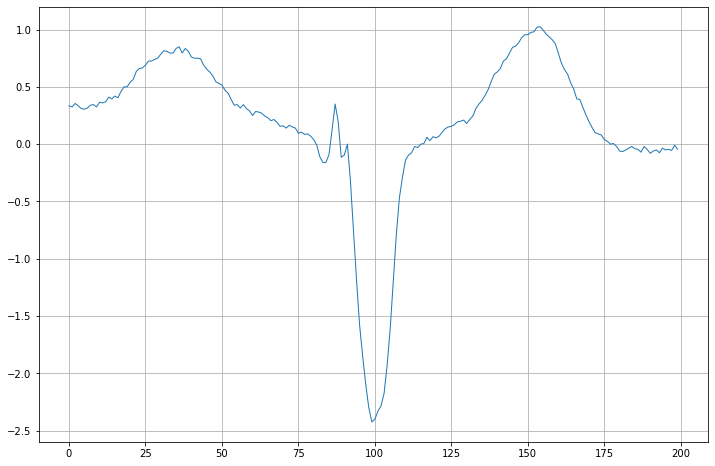

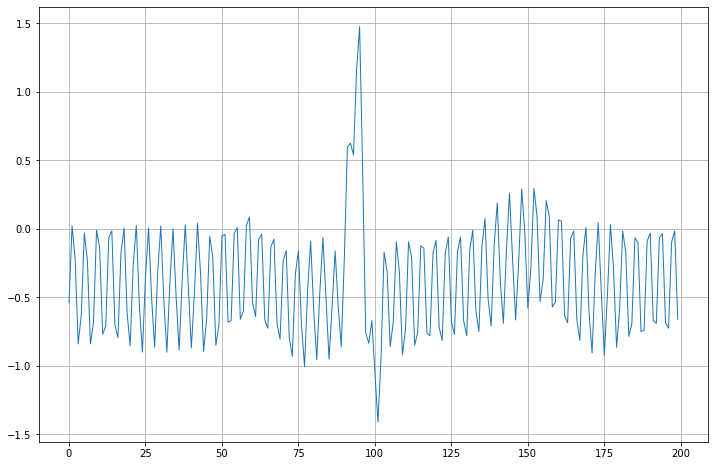

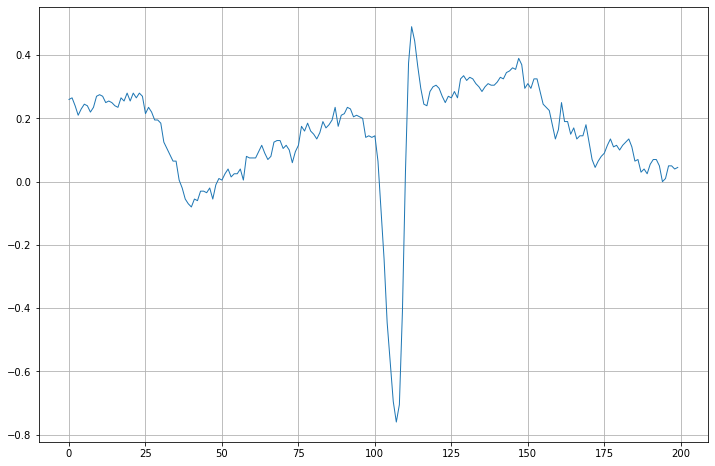

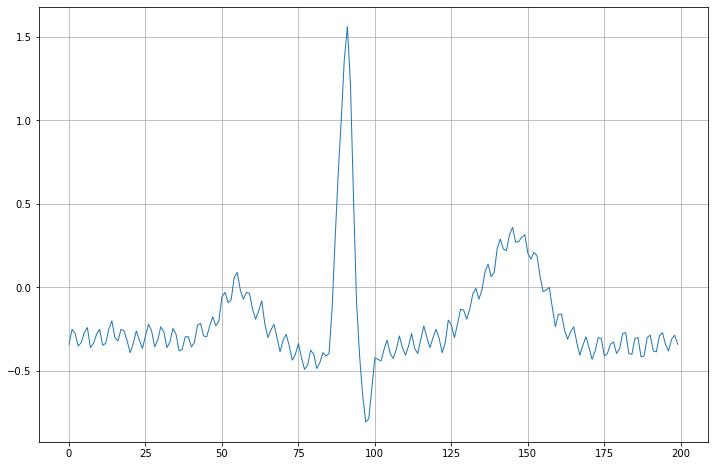

In [4]:
# I have already selected the beats to model earlier. Loading the beats only to generate synth afib beats now. 
afib_beats_to_model = pickle.load(open("afib_beats_to_model.p","rb"))

for beat in afib_beats_to_model:
    plt.figure(figsize=(12,8))
    plt.plot(beat)


#### The idea is to find the annotation where afib is happening and pick afib beat from each channel.Then plot 23 beats and find 10-15 good beats to get range values of fiducial points and store them in list.

#### This part is manual change the sample value, find out the indexes where the afib is happening.Pick one instance and plot the beat. Then store them in afib_beats_to_model list one by one.


sample = 22
afdb_records = wfdb.io.get_record_list('afdb')
afdb_records.remove('00735') #Corrupted Signal
afdb_records.remove('03665') #Corrupted Signal

atr = wfdb.rdann(afdb_records[sample], 'atr', pn_dir='afdb',summarize_labels=True) #reading annotation files for R_peak locations
print(atr.sample)


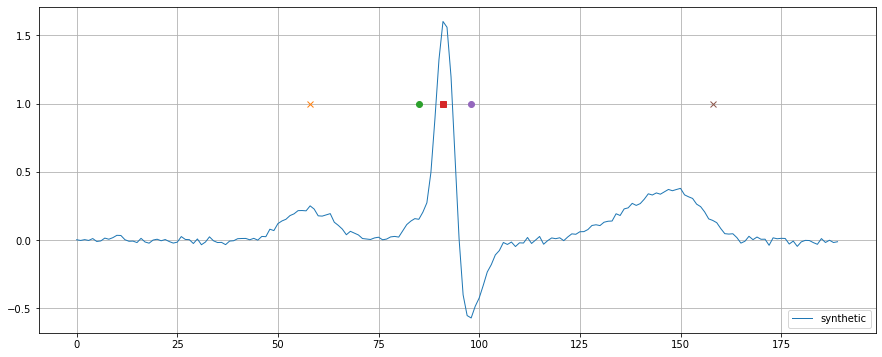

In [18]:
#This code block generates afib synthetic beats based on params. Params are set manually and plotted.

n=1
fs=250
params = (('pa', 0.3), ('qa', 0.2), ('ra', 2.2), ('sa', -0.8), ('ta', 0.5),
    ('pb', 0.2), ('qb', 0.1), ('rb', 0.07), ('sb', 0.06), ('tb', 0.4),
    ('pd', -0.15), ('qd', -0.04), ('rd', -0.015), ('sd', 0.01), ('td', 0.25),
    ('pm', 1.0), ('qm', 1.0), ('rm', 1.0), ('sm', 0.2), ('tm', 3.0),
    ('mu', 0.76), ('a', 1.2), ('std', 0.5), ('b', 0.075), ('bc', 0.1), ('bf', 1/3.6),
    ('alpha', 0.1), ('c', 0.3), ('wn', 0.0))
params_dict = dict(params)
ecg_clean, noise_stream, p_inds,q_inds,r_inds,s_inds,t_inds , synth_beat_time = generate_synth_beats(params_dict,n,fs)
synth_beat= ecg_clean+noise_stream
#beat = afib_beats_to_model[22]
#beat = StandardScaler().fit_transform(beat.reshape(-1,1))
#synth_beat = StandardScaler().fit_transform(synth_beat.reshape(-1,1))
plt.plot(synth_beat)
#plt.plot(beat)
plt.legend(["synthetic", "real"], loc ="lower right")
plt.plot(p_inds, np.ones(len(p_inds)),'x')
plt.plot(q_inds, np.ones(len(q_inds)),'o')
plt.plot(r_inds, np.ones(len(r_inds)),'s')
plt.plot(s_inds, np.ones(len(s_inds)),'o')
plt.plot(t_inds, np.ones(len(t_inds)),'x')

prm_obj_dump = transform_data(params)

pickle.dump(prm_obj_dump,open("synth_params/afib_synth_beat_22.p","wb"))

zz = pickle.load(open("synth_params/afib_synth_beat_15.p",'rb'))

zz



__params__= format_dict_as_tuples(zz)

print(__params__)

# Agenda:

-> Generate Synthetic Signals
    - Two options were proposed for RR Intervals
        1) Randomly pick 1 sample's rr intervals and create signal based on those RRIs
        2) Concatenate all the RRIs of samples and randomly pick 100
    - New AfibgenRR function to be written for AFIB
    - Don't use the Scaler on Synthetic signal
-> Read Documentation of How data is stored in pipeline.
-> Learn PyTorch
-> Explore Deeplearning repo
-> Start Writing Introduction, Literature Review.

# AFIB Signal Creation 

#### extract only those RR from sample's rr where afib is happening, then calculate the RRI and concatenate them to generate a list of RRIs so that randomly RRIs can be picked to generate synthetic afib signals. 

#### Record 07162 and 07859 contain only AFIB signals so only RR from those samples are used.  

#### https://physionet.org/lightwave/?db=afdb/1.0.0 


In [26]:
def format_dict_as_tuples(input_dict):
    return ', '.join(f"('{key}', {value})" for key, value in input_dict.items())

def rr_intervals(rpeaks):
       
    """
        Calculates RR intervals. 
        
        Parameters
        ----------
        rpeaks : wfdb object
           wfdb annotation object with rpeaks from ecg signal
        
        Returns
        -------
        rr_intervals in seconds, rr_intervals in samples 
    """
  
    rr_samp=np.diff(rpeaks)
    rr_intervals_sec=samp2sec(rr_samp)
    return rr_samp,rr_intervals_sec

def samp2sec(x): 
       
    """
       Changes samples to seconds. 
        
        Parameters
        ----------
        sample : numpy array
            numpy array of single channel ecg from the wfdbdb-records
        
        Returns
        -------
        Sample changed into seconds
    """
    return (x/250)

def extract_afib_rr(use_samples):
    all_RRIs = [] 
    
    for sample in use_samples:
        print(sample)
        qrs = wfdb.rdann(sample, 'qrs', pn_dir='afdb', summarize_labels=True)  # Reading annotation files for R-peak locations
        print(sample, ": ", qrs.sample)
        
        _, RRI = rr_intervals(qrs.sample)
        print(RRI)
        all_RRIs.extend(RRI)  # Concatenate RR intervals for the current sample
    
    return all_RRIs

def pick_random_RRIs(all_RRIs):
    # Check if the list contains at least 100 RRIs
    if len(all_RRIs) < 100:
        raise ValueError("The list of RR intervals contains fewer than 100 intervals.")
    
    # Randomly select 100 RRIs from the list
    random_RRIs = random.sample(all_RRIs, 100)
    
    return random_RRIs
    

all_RRIs = extract_afib_rr(['07162', '07859'])
RRIs = pick_random_RRIs(all_RRIs)
RRIs

07162
07162 :  [    348     581     710 ... 9000167 9000394 9000619]
[0.932 0.516 1.172 ... 0.716 0.908 0.9  ]
07859
07859 :  [    139     276     423 ... 8996986 8997127 8997274]
[0.548 0.588 0.62  ... 0.564 0.564 0.588]


[0.84,
 1.144,
 0.616,
 1.512,
 1.092,
 0.624,
 0.972,
 0.844,
 0.928,
 0.612,
 0.532,
 0.604,
 0.764,
 0.9,
 0.968,
 0.576,
 0.928,
 0.552,
 0.592,
 0.588,
 0.708,
 0.676,
 0.824,
 0.672,
 0.676,
 0.792,
 0.668,
 0.356,
 0.928,
 0.608,
 0.756,
 0.608,
 0.692,
 0.864,
 0.788,
 0.492,
 1.264,
 1.36,
 0.556,
 0.22,
 0.76,
 0.736,
 0.572,
 0.628,
 0.7,
 0.588,
 0.532,
 0.956,
 0.624,
 0.536,
 0.696,
 0.668,
 0.66,
 0.944,
 0.536,
 0.516,
 1.208,
 0.624,
 0.572,
 0.628,
 0.548,
 0.928,
 0.368,
 0.548,
 0.732,
 0.916,
 0.564,
 1.576,
 1.072,
 0.68,
 0.576,
 0.644,
 0.98,
 0.8,
 0.616,
 0.728,
 1.288,
 0.492,
 0.768,
 0.54,
 0.608,
 0.532,
 0.524,
 0.512,
 0.536,
 0.844,
 0.952,
 1.076,
 0.732,
 1.484,
 0.46,
 0.632,
 0.456,
 0.564,
 0.648,
 0.644,
 1.096,
 0.536,
 0.488,
 0.656]

Afib RRs:  [0.804, 0.768, 0.612, 0.52, 0.556, 0.588, 0.56, 0.864, 0.6, 0.672, 0.592, 1.004, 0.64, 1.204, 0.624, 0.84, 0.54, 0.588, 0.876, 0.496, 0.58, 0.644, 0.556, 0.588, 1.348, 1.112, 0.724, 0.568, 0.584, 0.62, 0.704, 0.648, 1.236, 0.672, 0.668, 0.684, 0.552, 0.528, 1.072, 0.66, 0.516, 0.7, 0.708, 0.472, 0.588, 0.564, 0.588, 1.332, 0.556, 0.516, 0.744, 0.524, 0.588, 0.56, 0.508, 0.728, 1.308, 0.664, 0.772, 0.608, 1.168, 0.604, 0.528, 0.576, 0.744, 0.832, 0.232, 0.728, 0.516, 0.628, 0.604, 0.768, 0.908, 0.992, 0.568, 0.548, 0.524, 1.26, 0.592, 1.176, 0.74, 0.484, 0.996, 0.576, 0.764, 0.64, 0.812, 0.608, 0.664, 0.652, 0.696, 0.852, 0.512, 0.424, 0.56, 0.552, 0.604, 0.496, 0.628, 1.124]


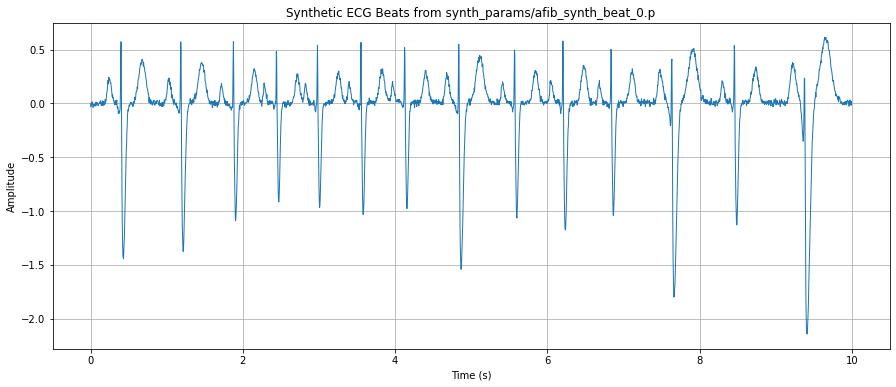

Afib RRs:  [0.6, 1.104, 0.536, 0.736, 0.568, 0.94, 0.68, 0.484, 0.596, 0.52, 0.516, 0.504, 0.664, 0.644, 1.124, 1.064, 0.516, 1.176, 1.2, 0.732, 0.54, 0.572, 0.632, 0.58, 0.604, 0.6, 0.54, 0.524, 0.712, 0.556, 1.032, 0.644, 0.884, 0.708, 0.76, 0.552, 0.936, 0.764, 0.632, 0.516, 0.572, 0.676, 0.752, 0.52, 0.928, 0.524, 0.584, 0.524, 0.76, 0.728, 0.864, 1.028, 1.236, 0.672, 0.532, 0.568, 0.656, 0.844, 0.784, 0.592, 0.992, 0.884, 0.644, 0.732, 0.512, 0.616, 1.316, 0.692, 0.7, 0.716, 1.412, 0.608, 0.464, 0.516, 1.432, 0.664, 0.672, 0.772, 0.564, 0.604, 0.608, 0.584, 0.508, 0.52, 1.38, 0.544, 0.616, 0.804, 0.616, 0.592, 0.568, 0.536, 0.488, 0.68, 0.468, 0.644, 1.18, 0.836, 0.524, 0.648]


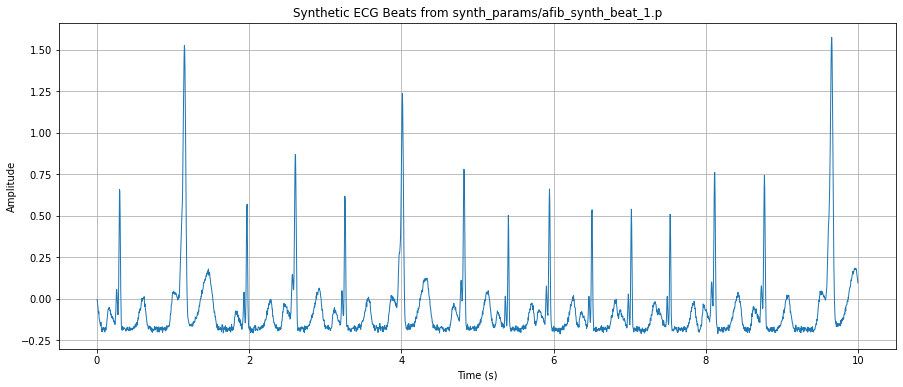

Afib RRs:  [0.472, 0.804, 1.3, 0.724, 0.64, 1.028, 0.628, 0.592, 0.608, 0.56, 0.556, 1.02, 0.532, 1.032, 1.256, 0.58, 0.564, 1.044, 0.608, 0.528, 0.636, 0.532, 0.864, 0.48, 0.724, 0.616, 0.708, 0.528, 0.672, 0.6, 0.796, 0.604, 0.54, 0.904, 0.5, 0.5, 0.6, 0.672, 0.592, 1.14, 0.936, 0.56, 0.536, 0.556, 0.556, 0.612, 0.592, 1.424, 0.532, 0.76, 0.772, 0.556, 0.508, 0.508, 1.148, 1.028, 0.648, 0.6, 0.588, 1.328, 0.964, 0.596, 0.596, 0.532, 0.572, 0.804, 0.652, 0.476, 0.66, 0.532, 1.38, 0.528, 0.816, 1.172, 0.976, 0.564, 0.548, 0.724, 1.124, 0.828, 1.084, 0.944, 0.544, 0.616, 0.932, 0.76, 1.116, 0.656, 0.86, 0.552, 1.044, 1.092, 0.492, 0.532, 0.484, 0.532, 0.512, 0.58, 0.728, 0.836]


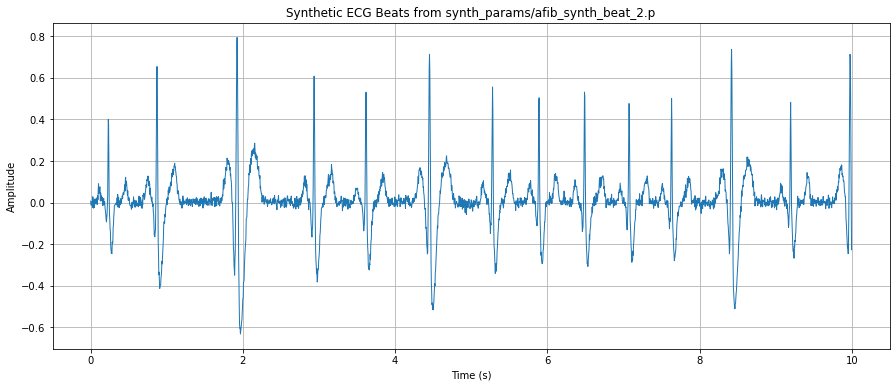

Afib RRs:  [0.588, 0.832, 0.6, 0.704, 0.588, 0.912, 1.0, 0.796, 0.812, 0.664, 0.58, 0.784, 0.708, 0.64, 0.492, 0.512, 0.708, 0.832, 0.824, 0.732, 0.516, 0.692, 0.512, 0.544, 0.604, 1.22, 0.712, 0.56, 0.576, 0.632, 0.948, 0.548, 1.148, 0.556, 0.792, 1.056, 0.536, 0.564, 1.684, 0.636, 0.52, 1.04, 0.484, 0.624, 1.08, 1.6, 1.16, 0.604, 1.432, 0.588, 0.588, 0.528, 0.58, 0.624, 0.692, 0.82, 0.636, 0.636, 0.604, 0.784, 1.108, 0.624, 0.56, 0.532, 0.576, 1.216, 0.588, 1.008, 0.528, 0.652, 0.552, 0.548, 0.632, 0.516, 0.616, 0.832, 0.536, 1.22, 0.608, 0.512, 0.66, 0.524, 0.532, 0.672, 0.692, 0.568, 0.848, 0.656, 0.804, 0.956, 1.724, 0.736, 0.48, 0.692, 0.928, 0.46, 0.596, 0.488, 0.736, 0.496]


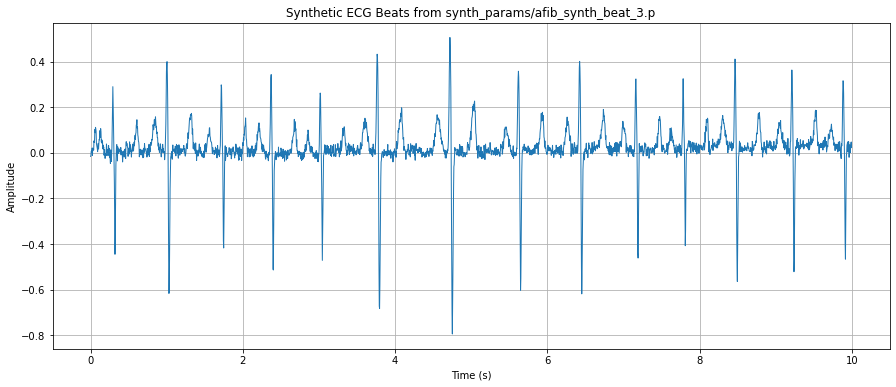

Afib RRs:  [0.892, 0.608, 0.7, 0.704, 0.584, 0.776, 0.496, 0.56, 0.664, 0.564, 0.484, 0.532, 0.496, 0.608, 0.58, 0.644, 1.088, 1.092, 1.024, 0.62, 0.548, 0.656, 0.548, 0.576, 0.62, 0.652, 0.68, 0.608, 0.724, 0.712, 0.62, 0.72, 1.164, 1.504, 0.536, 0.648, 0.556, 0.884, 0.72, 1.088, 0.576, 0.568, 0.524, 0.904, 0.56, 0.884, 0.732, 0.956, 0.652, 1.136, 0.648, 0.62, 0.568, 0.5, 1.256, 0.524, 1.068, 0.64, 0.456, 0.644, 0.6, 1.0, 0.532, 0.496, 0.556, 0.824, 1.44, 1.132, 0.532, 0.892, 0.724, 0.604, 1.3, 0.588, 0.584, 1.06, 0.664, 0.848, 0.588, 1.064, 0.516, 0.468, 0.548, 0.532, 0.56, 0.58, 0.556, 0.676, 0.608, 0.652, 0.52, 1.06, 0.588, 0.816, 0.688, 0.588, 0.564, 0.82, 0.544, 0.536]


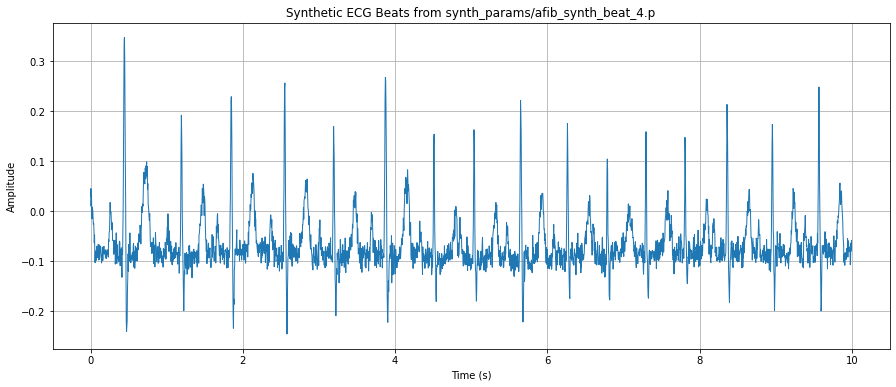

Afib RRs:  [0.588, 0.608, 0.488, 1.408, 0.528, 0.764, 0.836, 0.616, 1.168, 0.668, 1.412, 1.384, 0.644, 0.584, 0.992, 0.572, 1.104, 0.592, 0.676, 0.956, 1.2, 0.644, 0.584, 0.596, 0.768, 0.78, 0.544, 1.08, 1.104, 0.78, 0.716, 1.092, 1.264, 0.572, 0.6, 0.784, 0.624, 1.14, 0.568, 0.616, 0.64, 0.612, 0.596, 0.924, 0.524, 1.088, 0.592, 0.668, 0.676, 1.188, 0.672, 1.104, 0.544, 0.68, 0.832, 0.852, 0.584, 0.62, 0.7, 0.904, 0.6, 1.032, 1.056, 0.6, 0.552, 1.144, 0.524, 0.588, 0.56, 0.924, 0.54, 1.112, 1.076, 1.076, 0.688, 0.464, 0.74, 0.824, 0.864, 0.944, 0.796, 0.588, 0.904, 0.616, 0.928, 0.492, 0.936, 0.548, 0.748, 0.544, 0.62, 0.496, 0.676, 0.552, 0.608, 0.928, 0.8, 0.548, 0.976, 0.668]


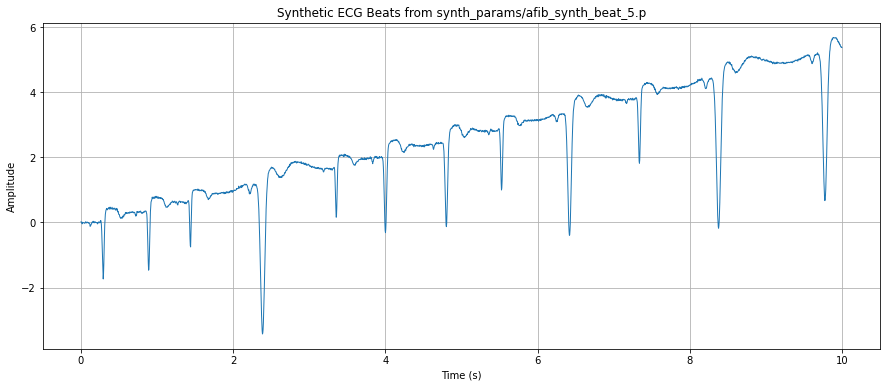

Afib RRs:  [0.632, 0.964, 0.728, 0.588, 0.64, 1.324, 0.548, 0.532, 1.336, 0.928, 0.604, 0.816, 0.712, 0.648, 1.236, 0.44, 0.944, 0.508, 1.192, 0.464, 0.664, 0.568, 0.64, 0.644, 1.1, 0.66, 0.952, 0.576, 0.564, 0.796, 0.508, 0.54, 0.56, 0.428, 1.548, 0.612, 1.268, 0.696, 0.516, 0.712, 1.036, 0.62, 1.012, 0.612, 0.588, 0.904, 0.824, 0.612, 0.656, 0.552, 0.664, 0.804, 0.944, 1.02, 0.54, 0.56, 0.652, 0.768, 0.84, 0.736, 0.86, 0.916, 0.552, 1.276, 1.564, 0.752, 1.308, 0.612, 0.728, 0.64, 0.584, 0.62, 0.836, 0.78, 0.952, 0.8, 0.588, 1.036, 0.684, 0.516, 0.628, 1.096, 0.572, 0.5, 0.5, 1.04, 0.924, 0.624, 0.58, 0.828, 0.624, 0.6, 0.588, 0.596, 1.592, 0.512, 0.564, 0.508, 1.132, 1.212]


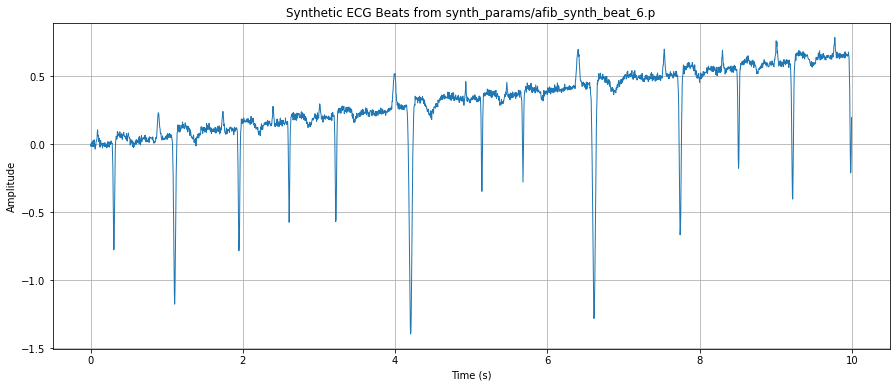

Afib RRs:  [0.692, 1.016, 0.94, 0.704, 0.676, 1.06, 0.492, 0.672, 0.62, 1.052, 0.664, 0.756, 0.936, 1.248, 0.992, 1.352, 0.68, 0.492, 0.336, 0.568, 0.568, 0.572, 0.56, 0.644, 0.836, 0.732, 0.728, 1.268, 0.56, 0.5, 0.664, 0.536, 1.056, 0.644, 0.548, 0.516, 0.64, 0.688, 0.584, 0.54, 0.408, 0.596, 0.58, 0.664, 0.648, 0.616, 0.808, 0.432, 0.492, 0.512, 0.624, 1.076, 0.656, 0.544, 0.584, 0.58, 0.448, 0.724, 0.708, 0.584, 1.236, 0.584, 1.32, 0.52, 0.836, 0.484, 0.856, 0.512, 0.76, 0.836, 0.516, 0.964, 0.892, 0.62, 0.544, 0.828, 0.712, 0.56, 0.508, 0.692, 1.372, 0.948, 0.592, 0.58, 0.572, 0.772, 0.656, 0.552, 1.332, 0.672, 0.896, 0.716, 0.732, 0.944, 0.492, 0.672, 0.584, 0.572, 0.72, 0.672]


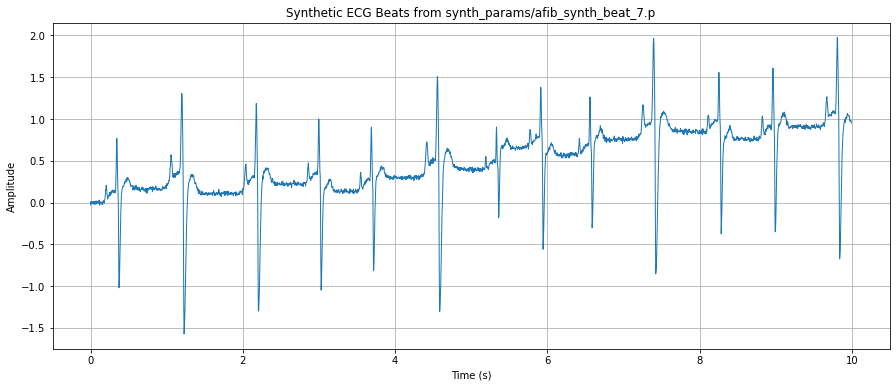

Afib RRs:  [0.612, 0.636, 0.464, 0.504, 0.636, 1.048, 0.952, 1.192, 0.584, 0.728, 0.6, 0.584, 0.58, 0.6, 1.532, 0.544, 0.512, 0.524, 1.164, 1.08, 1.208, 0.5, 0.624, 0.976, 0.632, 0.548, 0.592, 0.576, 0.92, 0.568, 0.64, 0.536, 1.136, 0.532, 0.476, 0.652, 0.608, 0.524, 0.88, 0.592, 0.552, 0.576, 0.636, 0.796, 0.488, 0.632, 0.604, 1.16, 0.924, 1.232, 0.592, 0.48, 0.78, 0.948, 0.588, 1.084, 1.084, 0.628, 0.64, 0.688, 0.748, 0.736, 0.684, 0.604, 0.548, 0.596, 0.58, 0.6, 0.556, 0.744, 0.596, 0.576, 0.584, 1.008, 0.516, 0.668, 0.876, 0.608, 0.744, 0.516, 0.672, 0.588, 0.552, 0.58, 0.488, 0.588, 0.804, 0.6, 0.66, 1.0, 0.664, 0.516, 0.704, 0.744, 0.98, 0.68, 0.884, 0.68, 1.108, 0.576]


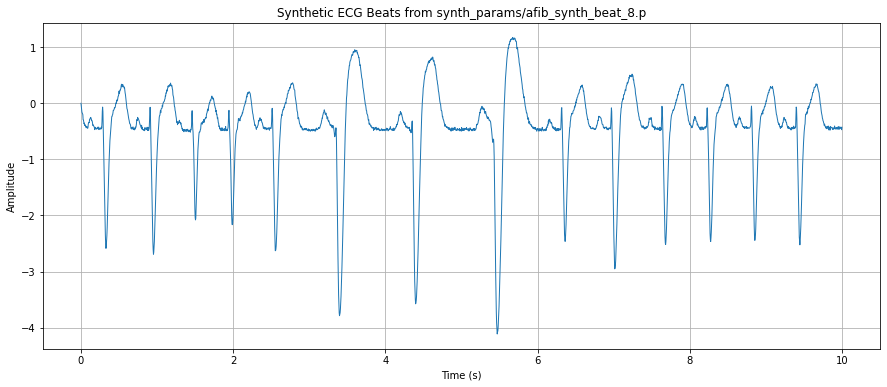

Afib RRs:  [0.82, 0.596, 0.528, 0.696, 0.612, 0.456, 0.608, 0.564, 0.512, 0.552, 0.632, 0.496, 0.584, 0.544, 0.64, 0.492, 0.608, 0.62, 0.544, 0.508, 0.636, 0.652, 0.584, 0.676, 0.56, 0.544, 0.888, 0.56, 0.532, 0.596, 0.576, 0.596, 0.7, 0.56, 0.784, 0.948, 1.04, 0.596, 1.316, 0.772, 0.928, 0.524, 0.468, 1.396, 0.768, 0.488, 0.98, 0.64, 0.476, 0.652, 0.544, 0.608, 0.524, 0.728, 1.264, 1.104, 0.716, 0.48, 0.512, 0.6, 1.152, 0.616, 0.948, 0.712, 0.66, 0.844, 0.656, 0.712, 0.576, 0.508, 0.552, 1.332, 0.728, 0.712, 0.536, 0.6, 1.14, 0.5, 0.868, 0.608, 0.564, 0.68, 0.776, 0.528, 0.716, 0.968, 0.528, 1.02, 0.696, 0.788, 0.852, 0.644, 0.72, 0.924, 0.52, 1.0, 0.584, 0.568, 1.156, 0.484]


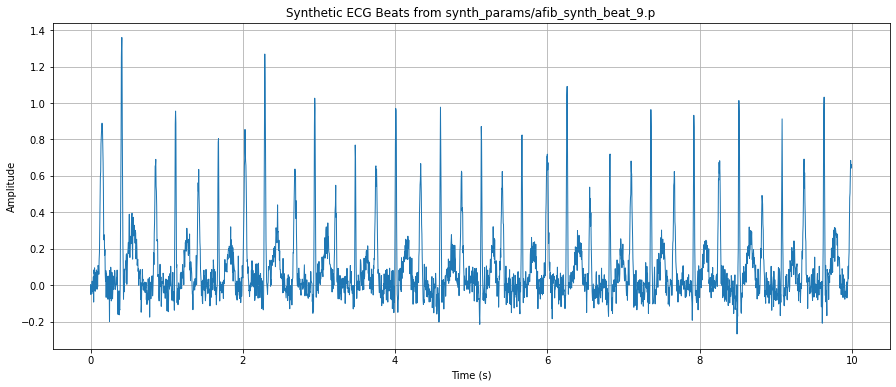

Afib RRs:  [0.448, 1.032, 0.74, 0.5, 0.732, 0.56, 0.584, 0.472, 0.472, 0.58, 0.592, 0.816, 0.476, 0.6, 0.676, 0.588, 0.62, 0.96, 0.56, 1.292, 0.62, 0.656, 0.632, 0.952, 0.664, 0.912, 0.568, 0.576, 0.812, 0.66, 0.56, 0.972, 0.808, 0.584, 0.608, 0.596, 0.512, 0.648, 0.6, 0.66, 0.812, 0.508, 0.644, 0.572, 0.648, 0.584, 1.592, 0.472, 1.1, 0.564, 0.504, 1.428, 0.624, 0.728, 0.972, 0.444, 0.668, 0.492, 0.724, 0.92, 0.636, 0.744, 0.892, 0.992, 0.784, 0.58, 0.512, 0.548, 0.544, 0.816, 0.62, 0.536, 0.84, 0.544, 0.6, 0.616, 0.596, 0.58, 1.064, 1.364, 0.676, 0.564, 0.784, 0.74, 0.648, 0.56, 0.584, 0.48, 0.552, 0.836, 0.616, 0.564, 0.7, 0.588, 0.544, 1.224, 0.784, 0.712, 0.676, 0.852]


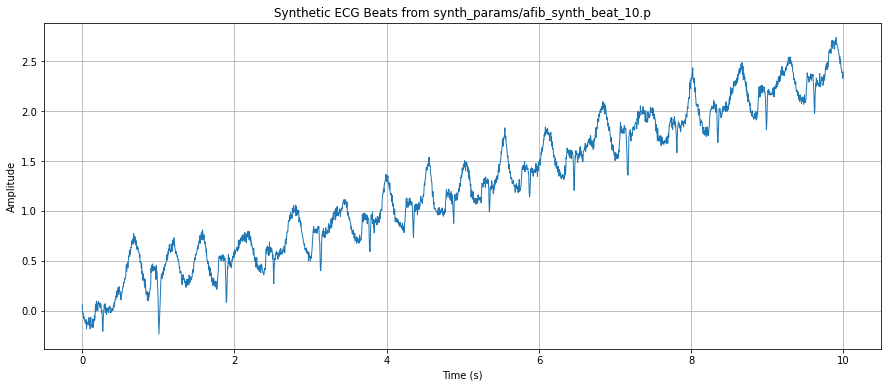

Afib RRs:  [0.94, 0.604, 0.768, 0.392, 0.536, 0.628, 0.684, 0.612, 0.88, 0.808, 0.864, 0.536, 0.692, 0.804, 0.532, 1.088, 1.256, 0.616, 0.468, 0.568, 0.596, 0.788, 0.5, 0.576, 0.576, 0.668, 0.768, 0.364, 0.66, 0.54, 0.82, 0.816, 0.528, 0.688, 0.64, 0.48, 0.632, 0.576, 0.86, 1.096, 0.608, 0.644, 0.616, 0.616, 0.628, 1.02, 0.616, 0.604, 0.704, 0.452, 0.628, 0.576, 0.744, 0.616, 0.652, 0.556, 0.484, 0.54, 0.788, 0.776, 0.52, 0.564, 0.456, 0.692, 0.872, 0.54, 0.572, 0.808, 0.58, 0.608, 0.708, 1.152, 0.6, 0.676, 0.94, 0.612, 0.568, 0.912, 0.544, 0.748, 0.78, 0.66, 0.532, 0.58, 0.536, 0.652, 0.816, 0.248, 0.784, 1.512, 0.596, 0.748, 0.612, 0.7, 0.588, 0.82, 0.668, 0.96, 0.54, 1.028]


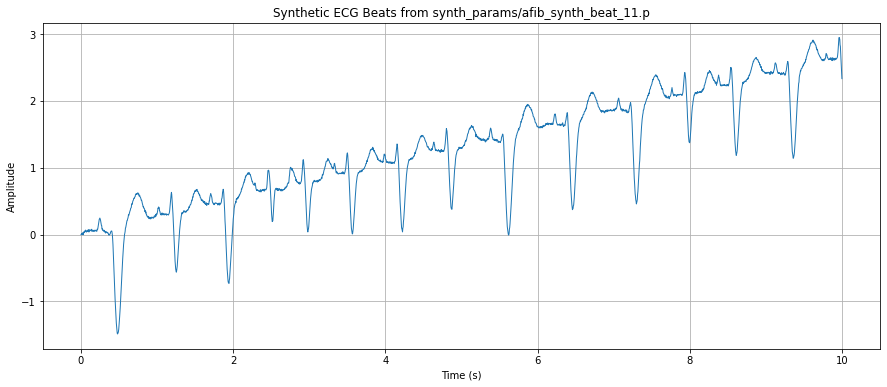

Afib RRs:  [0.52, 0.928, 0.552, 0.632, 0.956, 0.768, 1.064, 0.564, 0.576, 0.584, 0.856, 0.608, 0.648, 0.968, 0.572, 0.804, 0.636, 0.608, 1.052, 0.904, 0.448, 0.532, 0.832, 0.644, 0.52, 0.636, 0.564, 0.988, 0.944, 1.256, 0.744, 0.576, 0.94, 0.672, 0.592, 0.688, 0.564, 0.536, 0.564, 1.184, 0.536, 1.104, 0.664, 1.3, 0.94, 0.504, 0.736, 0.664, 0.476, 1.324, 1.02, 0.684, 0.98, 0.876, 0.652, 0.724, 1.328, 0.488, 0.744, 0.764, 0.604, 0.896, 0.876, 0.592, 0.512, 1.14, 0.624, 0.612, 0.468, 0.548, 0.576, 0.624, 0.652, 0.54, 0.612, 0.724, 1.08, 0.548, 0.5, 0.516, 0.58, 1.176, 0.5, 0.568, 1.172, 0.536, 0.928, 0.656, 0.62, 0.656, 0.692, 0.596, 0.588, 0.444, 0.452, 0.608, 0.768, 0.524, 0.516, 0.54]


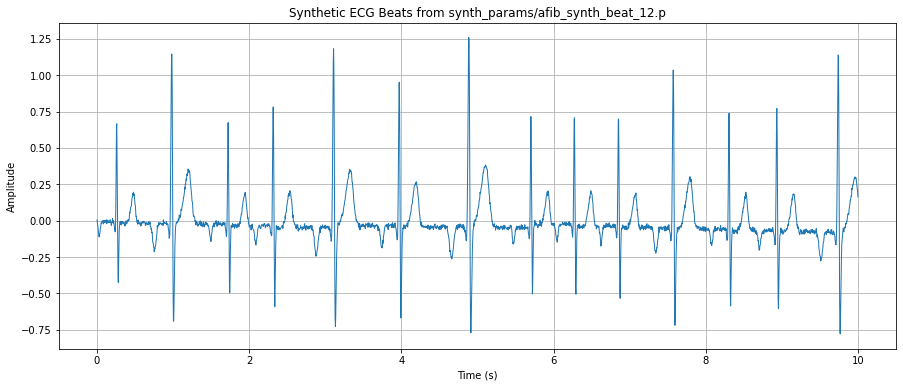

Afib RRs:  [0.668, 1.696, 0.796, 0.6, 0.66, 1.096, 0.944, 0.576, 0.552, 0.612, 0.788, 0.956, 0.528, 0.596, 1.068, 1.2, 1.16, 0.692, 0.516, 0.776, 0.512, 0.564, 1.104, 0.476, 0.756, 0.916, 0.672, 0.908, 0.636, 0.572, 0.844, 0.656, 1.332, 1.292, 0.952, 1.288, 0.836, 0.556, 0.532, 0.68, 0.492, 0.512, 0.876, 0.812, 0.724, 0.916, 0.696, 1.104, 0.784, 0.632, 0.64, 1.012, 0.592, 0.548, 0.52, 0.556, 1.144, 0.516, 0.764, 0.604, 0.576, 0.44, 0.572, 0.872, 0.684, 0.688, 0.556, 0.512, 0.58, 0.62, 0.732, 1.372, 0.804, 0.676, 0.708, 0.6, 0.64, 0.916, 0.612, 0.52, 0.668, 0.844, 0.716, 0.58, 0.628, 0.648, 0.688, 1.032, 0.556, 0.716, 0.592, 0.776, 0.708, 1.168, 0.836, 0.516, 0.6, 0.612, 0.676, 0.916]


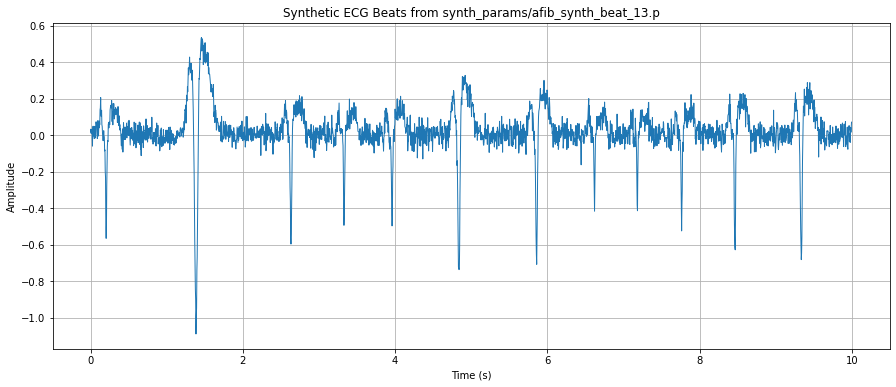

Afib RRs:  [0.692, 0.628, 0.792, 0.576, 0.588, 0.616, 0.636, 0.788, 0.492, 0.64, 0.66, 0.78, 0.892, 0.48, 0.588, 0.576, 0.548, 0.936, 0.576, 0.56, 0.516, 0.528, 0.592, 0.504, 0.568, 0.604, 0.992, 0.664, 0.792, 0.532, 0.624, 0.616, 0.968, 0.88, 0.5, 1.012, 0.872, 0.62, 0.612, 0.688, 0.568, 0.528, 0.62, 0.632, 0.592, 0.888, 0.788, 0.6, 0.5, 0.652, 1.036, 0.632, 0.62, 0.96, 0.728, 0.548, 0.488, 0.82, 0.704, 1.36, 0.516, 0.676, 0.6, 0.512, 0.844, 0.54, 0.792, 0.804, 0.604, 0.66, 0.772, 0.512, 0.604, 1.416, 0.624, 0.688, 0.492, 0.556, 0.544, 0.94, 0.688, 0.548, 0.732, 0.612, 0.656, 0.924, 0.624, 0.572, 0.56, 0.544, 0.748, 1.208, 0.984, 0.572, 0.792, 0.468, 1.112, 0.532, 0.896, 0.708]


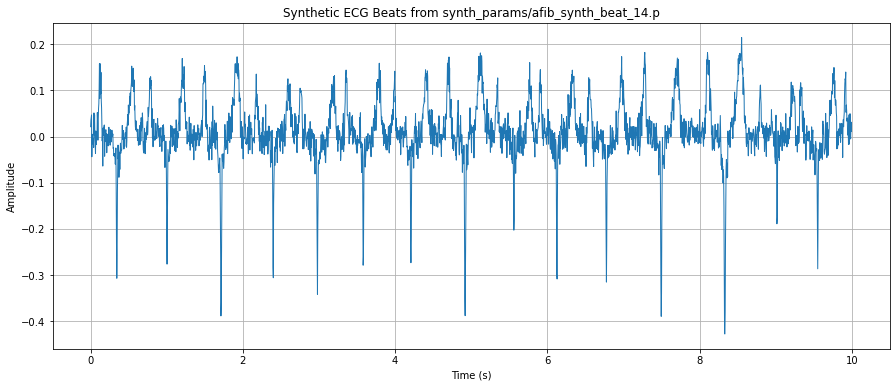

Afib RRs:  [0.82, 1.508, 0.664, 1.084, 0.704, 0.82, 0.624, 0.548, 0.488, 0.7, 0.46, 0.656, 0.94, 0.568, 0.604, 0.488, 0.58, 0.656, 0.564, 0.484, 0.508, 0.604, 0.964, 0.52, 0.616, 0.612, 0.76, 0.632, 0.6, 0.54, 0.62, 0.524, 0.824, 0.52, 0.644, 0.464, 0.616, 1.236, 0.632, 0.536, 1.192, 0.564, 0.488, 0.628, 0.596, 0.548, 0.584, 0.524, 0.48, 0.54, 0.644, 0.648, 0.536, 0.48, 1.116, 0.632, 0.548, 0.456, 0.564, 0.86, 0.524, 0.92, 0.56, 0.46, 0.828, 0.48, 0.564, 0.644, 0.528, 0.668, 0.52, 1.024, 0.616, 1.196, 0.528, 1.208, 0.584, 0.552, 1.06, 0.648, 0.532, 0.54, 0.536, 0.792, 0.428, 1.056, 0.584, 0.548, 0.544, 0.504, 0.644, 0.596, 0.596, 0.708, 0.524, 0.612, 0.804, 0.484, 0.528, 0.588]


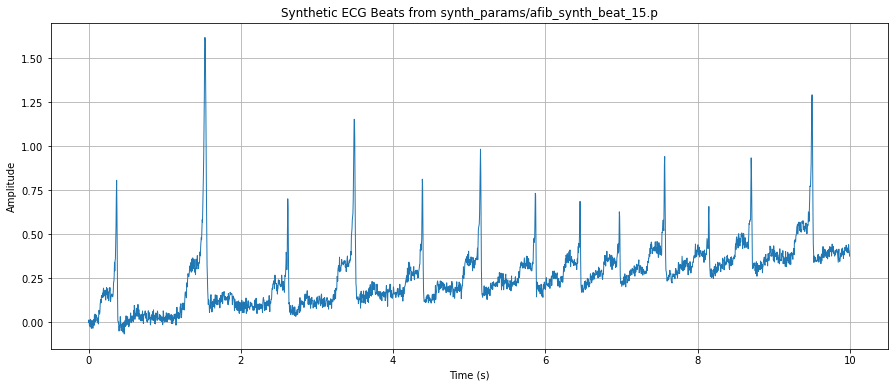

Afib RRs:  [1.08, 1.032, 0.532, 0.596, 0.572, 1.0, 0.604, 0.572, 0.74, 0.72, 0.908, 0.52, 0.756, 0.532, 1.296, 0.608, 0.624, 0.64, 0.604, 0.66, 0.572, 0.62, 1.424, 0.456, 0.776, 1.14, 0.516, 1.036, 0.548, 0.876, 0.576, 0.916, 0.576, 0.808, 0.556, 1.092, 1.088, 0.92, 0.952, 0.492, 0.604, 0.588, 1.192, 0.52, 0.524, 1.248, 1.26, 0.692, 0.528, 0.76, 0.68, 0.596, 0.7, 0.568, 0.576, 0.656, 1.008, 0.68, 0.64, 0.66, 0.66, 0.608, 0.968, 1.316, 0.568, 0.624, 0.588, 0.496, 0.616, 0.576, 0.852, 0.5, 1.16, 0.6, 0.544, 0.604, 0.596, 0.616, 0.6, 1.484, 0.504, 0.848, 0.74, 0.72, 0.648, 1.096, 0.564, 0.712, 1.18, 0.532, 0.6, 0.64, 1.104, 0.748, 0.52, 0.612, 0.572, 0.932, 0.616, 0.608]


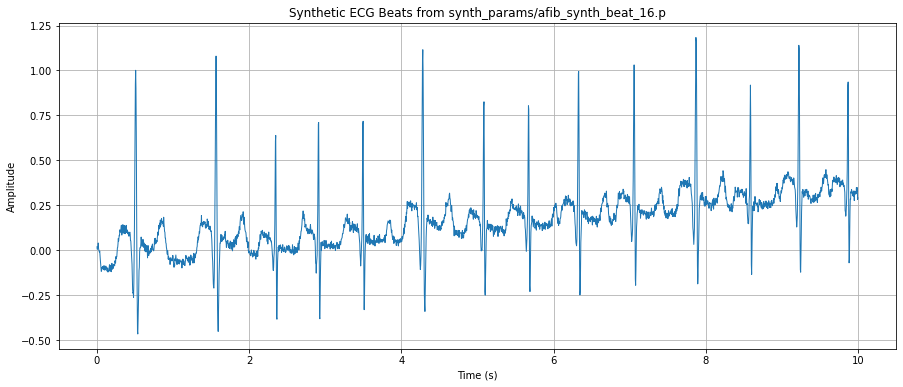

Afib RRs:  [0.476, 1.116, 1.028, 0.588, 1.012, 0.612, 0.516, 0.852, 0.688, 0.596, 0.508, 0.532, 0.572, 0.532, 0.824, 1.188, 0.56, 0.596, 0.564, 0.636, 0.684, 0.988, 0.468, 0.904, 0.536, 0.596, 0.668, 1.016, 0.828, 0.644, 0.464, 0.944, 0.676, 1.304, 0.676, 0.716, 0.548, 0.604, 1.3, 0.668, 0.744, 0.592, 0.608, 0.812, 0.616, 0.92, 0.736, 0.816, 0.568, 0.46, 0.828, 0.668, 1.072, 0.812, 0.712, 0.924, 0.608, 0.576, 0.96, 0.548, 1.104, 0.812, 0.684, 0.636, 0.7, 1.204, 0.8, 1.02, 0.528, 0.544, 1.192, 0.556, 0.568, 0.952, 0.692, 1.14, 0.628, 0.512, 0.924, 1.56, 0.516, 0.652, 0.612, 0.5, 0.656, 0.832, 0.492, 0.732, 0.644, 0.604, 0.66, 0.644, 0.812, 0.592, 0.58, 0.648, 0.784, 0.612, 0.84, 1.02]


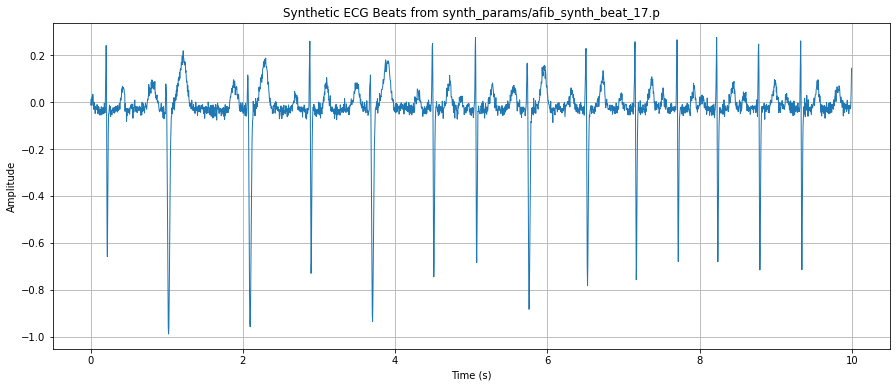

In [35]:
# Define the number of beats to generate from each file
num_beats_per_file = 1

# Loop over each pickle file
for i in range(18):
    pickle_file = f"synth_params/afib_synth_beat_{i}.p"
    
    # Load synthetic beat parameters from the pickle file
    synth_beat_params = pickle.load(open(pickle_file, 'rb'))

    # Create a new figure for each file
    plt.figure()

    # Loop for generating and plotting synthetic beats
    for n in range(num_beats_per_file):
        fs = 250  #fs
        params = synth_beat_params
        RRIs = pick_random_RRIs(all_RRIs)
        # Generate synthetic beats
        ecg_clean, noise_stream, p_inds, q_inds, r_inds, s_inds, t_inds, synth_beat_time = generate_synth_beats(params, n, fs,mode="afib",rr=RRIs)
        synth_beat = ecg_clean + noise_stream
        t = np.linspace(0, len(synth_beat)/250, len(synth_beat))

        # Plot synthetic beat
        plt.plot(t[:2500], synth_beat[:2500])
    
    # Set title and labels for each plot
    
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Synthetic ECG Beats from {pickle_file}')
    plt.show()